# Text Classification using BERT

## Setup Notebook

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebook is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"

**Installs**

We will install Huggingface’s transformers library. This library let us import a wide range of transformer-based pre-trained models such as BERT.

In [1]:
!pip install transformers

**Imports**

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Transformers
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding,
    create_optimizer
)

**Verify Setup**

It is a good practice to verify what version of TensorFlow you are using. Also verify if GPU is enabled and what GPU you have.

In [3]:
# TF version
print("Tensorflow version", tf.__version__)

# GPU Setup
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

Tensorflow version 2.19.0
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a A100, V100, P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [4]:
!nvidia-smi

Sun Jan 18 15:10:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             31W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Text Classification

### **Overview**

In this example, we're going to be working with news articles from CNN. We will explore the dataset, prepare the data for modeling, and pretrained BERT.

**The Task:** Classify news articles into three categories, namely politics, health, and entertainment.

### **Dataset**

The dataset consists of news articles pulled from CNN in the politics, health, and entertainment categories. There are about 300 articles in each category.

#### **Download**

Download the datasets to colab.

In [5]:
# Download the news dataset
file_path = tf.keras.utils.get_file(
    fname="news300.zip",
    origin="https://github.com/dlops-io/datasets/releases/download/v1.0/news300.zip",
    extract=True)
data_dir = file_path.replace("news300.zip", "news300")
print("data_dir:", data_dir)

data_dir: /root/.keras/datasets/news300


#### **Load Data**

* Read-in data as lists.
* Each element in data_x is the content of a sample, namely an news article.
* Each element in data_y is the label of that article.

In [6]:
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names)

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
    text_files = os.listdir(os.path.join(data_dir, label))
    data_x.extend([os.path.join(data_dir, label, f) for f in text_files])
    data_y.extend([label for f in text_files])

# Load the text content
for idx, path in enumerate(data_x):
    with open(path) as file:
        data_x[idx] = file.read()

# Preview
print("data_x count:", len(data_x))
print("data_y count:", len(data_y))
print("Label counts:", np.unique(data_y, return_counts=True))

Number of classes: 3
Labels: ['entertainment', 'health', 'politics']
data_x count: 920
data_y count: 920
Label counts: (array(['entertainment', 'health', 'politics'], dtype='<U13'), array([310, 310, 300]))


#### **View Text**

Let's take a look at the data.

In [7]:
data_x[0]

'\'Tenet\'s\' rough start at the box office signals a bleak fall for US theaters New York (CNN Business)For American theaters, "Tenet" was supposed to be the film that brought audiences back to the movies. There was just one problem: "Tenet" opened, and hardly anyone showed up. Warner Bros.\' new Christopher Nolan spy thriller has made roughly $30 million domestically since opening in North America two weeks ago. That includes two pretty lackluster weekends where the film made about $9.5 million and $6.7 million at the box office. (Warner Bros., like CNN, is owned by WarnerMedia.) For Warner Bros., the news isn\'t all bad since "Tenet" has performed admirably overseas. The film, which opened internationally in late August, has brought in more than $205 million globally so far. However, for domestic theaters, "Tenet\'s" rough start puts a considerable strain on an industry that needed a blockbuster to entice moviegoers back to the cineplex.  \'Beyond bleak\' With no other big film on th

In [8]:
data_y[0]

'entertainment'

In [9]:
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i, data_idx in enumerate(data_samples):
  print("Label:",data_y[data_idx],", Text:",data_x[data_idx])

Label: health , Text: AstraZeneca's Oxford vaccine trial to resume, the university says  (CNN)The AstraZeneca coronavirus vaccine trial, halted last week after an unexplained illness in one of the volunteers, will resume, the University of Oxford announced Saturday. The university, which is developing the vaccine with AstraZeneca, did not say when the trial would resume. AstraZeneca said the trial will only resume in the United Kingdom, adding that it's working with health authorities across the world to determine when other trials can resume.  Before the pause, the company was testing its vaccine, dubbed the Oxford vaccine, in the United States as well as in the United Kingdom, Latin America, Asia, Europe and Africa. The university said in a statement that some 18,000 individuals around the world have received study vaccines as part of the trial. "In large trials such as this, it is expected that some participants will become unwell and every case must be carefully evaluated to ensure

#### **Split Data**
We split data into train and validation by randomly selecting 20% as the validation set.

In [10]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


### **Text Classificaton pretrained BERT**

#### **Build Data Pipelines**

**Text Tokenization** ([Reference](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer))

In [11]:
# Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Tokenizer Example
text = [
    "What you need to know about using them safely amid the pandemic",
    "A third of Medicare enrollees with coronavirus ended up in the hospital"
]
outputs = tokenizer(
    text,
    padding="max_length",
    truncation=True,
    max_length=15,
    return_tensors="tf"
)
print("Tokenizer Output keys:", outputs.keys())
print("Input IDs shape:", outputs["input_ids"].shape)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizer Output keys: KeysView({'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>})
Input IDs shape: (2, 15)


* Input ids: are the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.
* Attention mask: is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.
* Token type ids: Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be joined in a single “input_ids” entry, which usually is performed with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. For example, the BERT model builds its two sequence input as such:

* Here, we will tokenize news articles. To setup for BERT, we need to add special tokens,  namely [CLS] at the beginning and [SEP] at the end of each sentence. Also, we need to pad or truncate all sentences to a single constant length.

##### **Create TF Datasets**

In [13]:
BATCH_SIZE = 8
sequence_length = 256

# Tokenize training data
train_x_processed = tokenizer(
    train_x,
    padding="max_length",
    truncation=True,
    max_length=sequence_length,
    return_tensors="tf"
)

# Tokenize validation data
validate_x_processed = tokenizer(
    validate_x,
    padding="max_length",
    truncation=True,
    max_length=sequence_length,
    return_tensors="tf"
)

# Convert labels to indices
train_processed_y = np.array([label2index[label] for label in train_y])
validate_processed_y = np.array([label2index[label] for label in validate_y])

# One-hot encode labels
train_processed_y = tf.keras.utils.to_categorical(
    train_processed_y, num_classes=num_classes, dtype="int32"
)
validate_processed_y = tf.keras.utils.to_categorical(
    validate_processed_y, num_classes=num_classes, dtype="int32"
)

# Create TF Datasets
train_data = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_x_processed["input_ids"],
        "attention_mask": train_x_processed["attention_mask"],
        "token_type_ids": train_x_processed["token_type_ids"],
    },
    train_processed_y,
))

validation_data = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": validate_x_processed["input_ids"],
        "attention_mask": validate_x_processed["attention_mask"],
        "token_type_ids": validate_x_processed["token_type_ids"],
    },
    validate_processed_y,
))

# Optimize datasets
train_data = train_data.shuffle(len(train_x)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### **Train**

In [14]:
learning_rate = 2e-5
epochs = 5
num_train_steps = len(train_data) * epochs

# Build model
model = TFAutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-uncased",
    num_labels=3,
    from_pt=True
)

# Print model architecture
print(model.summary())

# Optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=0.01,
    epsilon=1e-8
)

# Loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Metrics
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
]

# Compile model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

# Train model
print("\n=== Training Model ===")
start_time = time.time()

training_results = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs,
    verbose=1
)

execution_time = (time.time() - start_time) / 60.0
print(f"\nTraining execution time: {execution_time:.2f} mins")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

=== Training Model ===
Epoch 1/5
92/92 [==============================] - 275s 1s/step - loss: 0.6406 - accuracy: 0.7486 - val_loss: 0.2856 - val_accuracy: 0.9239
Epoch 2/5
92/92 [==============================] - 72s 781ms/step - loss: 0.1923

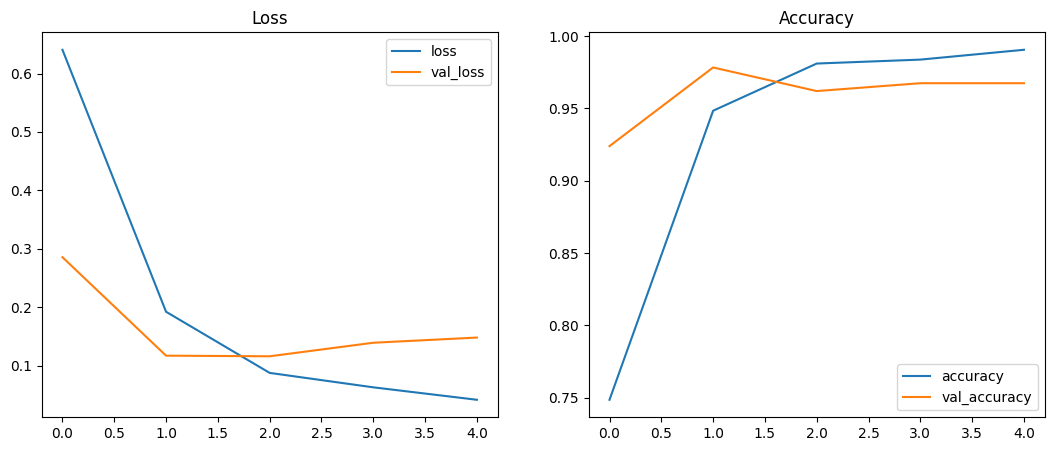

In [15]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title("Loss")
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title("Accuracy")
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

#### **Make Predictions**

In [16]:
# Generate a random sample of index
data_samples = np.random.randint(0, high=len(validate_x) - 1, size=5)

for i, data_idx in enumerate(data_samples):
    print("Text:", validate_x[data_idx])

    # Tokenize text
    test_x_processed = tokenizer(
        [validate_x[data_idx]],
        padding="max_length",
        truncation=True,
        max_length=sequence_length,
        return_tensors="tf"
    )

    # Make prediction
    predictions = model.predict(test_x_processed, verbose=0)

    # Get predicted class
    predicted_idx = predictions.logits.argmax(axis=1)[0]
    predicted_label = index2label[predicted_idx]

    print("Label:", validate_y[data_idx])
    print("Predicted Label:", predicted_label)
    print()

Text: Killer Mike to receive inaugural Billboard Change Maker Award    (CNN)Rapper and social activist Killer Mike has been announced as the first recipient of the Billboard Change Maker Award. The announcement was made Monday by Dick Clark Productions and NBC which will host the upcoming Billboard Awards. The award "honors the artist or group that speaks truth to power through their music, celebrity and community." "They are socially conscious, politically aware, active in their community and charitable with time, money and/or influence to improve the lives of others," according to a news release about the announcement.  "Killer Mike's dedication to equality, social justice and financial literacy in the Black community has catapulted him as a headlining figure of social responsibility and activism, as demonstrated in the wake of the slayings of Ahmaud Arbery, George Floyd, Breonna Taylor and Rayshard Brooks." One half of the hip hop duo Run the Jewels, Killer MIke has spent much of hi